In [32]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from  matplotlib.colors import LinearSegmentedColormap
import pandas as pd
import seaborn as sn
import sys
from pathlib import Path
from tqdm import tqdm
import scipy

import torch.nn as nn
from torch import Tensor
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.optim as optim

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

# import custom functions from src folder
module_path = str(Path.cwd() / "../src")

if module_path not in sys.path:
    sys.path.append(module_path)

from SequentialNet import SequentialNet
from machine_learning import *
from util import *

In [33]:
def word_to_int(df):
    # Red = 0, blue = 1
    df["class"] = 0
    df_copy = df.copy()
    mask = df_copy["color"] == "blue"
    df.loc[mask, "class"] = 1
    return df

def label_maker(values, num_classes):
    labels = np.zeros((len(values), num_classes))
    for i, value in enumerate(values):
        labels[i][value] = 1
    return torch.Tensor(labels).to(torch.int)

In [34]:
def plot_results(df, pred_key, ax, suptitle, error_key="None"):
    ax.set_title(suptitle)
    cmap = red_blue_cmap()
    if error_key == "None":
        sn.scatterplot(data = df, x="x1", y="x2", ax = ax, hue=pred_key, 
                    hue_norm = mpl.colors.Normalize(vmin=0, vmax=1, clip=False),
                        palette=cmap, legend=False)
    else:
        sn.scatterplot(data = df, x="x1", y="x2", ax = ax, hue=pred_key, 
                       size=error_key, size_norm = (0.1, 0.3), sizes=(10, 200),
                        hue_norm = mpl.colors.Normalize(vmin=0, vmax=1, clip=False),
                        palette=cmap, legend=False)
    
    ax.set_xlim(-25, 25)
    ax.set_ylim(-25, 25)
    ax.set_xlabel(r"x$_1$", fontsize=14)
    ax.set_ylabel(r"x$_2$", fontsize=14)

    ax.tick_params(which="both", direction="inout", bottom=True, left=True, labelsize=14, pad=5, length=4, width=1)
    ax.tick_params(which="major", length=6)
    ax.set_xticks([-20, 0, 20])
    ax.set_yticks([-20, 0, 20])
    ax.set_aspect('equal', adjustable='box')
    ax.minorticks_on()
    return ax


In [35]:
def predict_grid(model, x1_key, x2_key, device, mcdropout:bool = False, nx:int = 100):
    x1_lim = 25
    x2_lim = 25
    x1 = np.linspace(-x1_lim, x1_lim, nx)
    x2 = np.linspace(-x2_lim, x2_lim, nx)
    xx1, xx2 = np.meshgrid(x1, x2)
    df = pd.DataFrame(columns = ["x1", "x2"], index = range(len(xx1.flatten())))
    df["x1"] = xx1.flatten()
    df["x2"] = xx2.flatten()
    df = cartesian_to_polar_df(df, "x1", "x2", "r_x", "a_x")

    X_gridtest = torch.Tensor(np.dstack((df[x1_key], df[x2_key]))).to(torch.float32)[0]
    Y_gridtest = torch.zeros(X_gridtest.shape)
    gridtest_dataset = torch.utils.data.TensorDataset(X_gridtest, Y_gridtest)
    if mcdropout:
        mean_val, variance_val = mc_predictions(model, gridtest_dataset, 2**8, 100, 2, len(df))
        preds = np.argmax(mean_val, axis=-1).flatten()
        df["Prediction_MC"] = preds
        #Get average softmax score for blue
        df["Confidence_MC"] = scipy.special.softmax(mean_val, axis=-1)[:,0]
        # Error is the same for both scores
        df["Error_MC"] = np.sqrt(variance_val[:,0])
    else:
        truth, logits = predict_classifier(model, gridtest_dataset, 2, 100, device)
        preds = torch.argmax(logits, dim=-1).flatten()
        df["Prediction"] = preds
        #Get softmax score for red
        df["Confidence"] = torch.softmax(logits, dim=-1)[:,0]
    return df

In [36]:
# Set up device
device = (
    "cuda:0"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device {torch.cuda.get_device_name(0)}")

Using cuda:0 device NVIDIA TITAN V


In [37]:
# Machine learning options
x1_key = "x1"
x2_key = "x2"
n_data = [250, 1000, 2000, 3000, 4000, 5000]
patience = 15
load_ensemble_values = True

#Data constants
R2 = 3
k_red = 7
k_blue = 3
R1_min = 6
scale = 1
vary_a1 = False
vary_R2 = False
p_red = 0.5
polar = True
tag = f'r2_{R2}_kr{k_red}_kb{k_blue}_r1min{R1_min}_s{scale}_vary_r2_{vary_R2}_vary_a1_{vary_a1}_pRed_{p_red}'

# Read files
train_n = 50000
trainfile = f"train_n_{train_n}_{tag}"
valfile = f"val_n_5000_{tag}"
truthfile = f"analytical_solution_x1_x2_grid_{tag}_nxMC_100_nr1MC_50"
testfile = "x1_x2_grid"

train_data = pd.read_csv(f"../data/{trainfile}.csv")
val_data = pd.read_csv(f"../data/{valfile}.csv")
test_data = pd.read_csv(f"../data/{testfile}.csv")
truth_data = pd.read_csv(f"../analytical/{truthfile}.csv")

#Correct analytical solution if class distribution is not equal
if p_red != 0.5:
    truth_data["P_red_and_x"] = truth_data["P_red_and_x"]*(p_red)/0.5
    truth_data["P_blue_and_x"] = truth_data["P_blue_and_x"]*(1-p_red)/0.5
    truth_data["P_x"] = truth_data["P_red_and_x"] + truth_data["P_blue_and_x"]
    truth_data["P_red_given_x"] = truth_data["P_red_and_x"]/truth_data["P_x"]
    truth_data["P_blue_given_x"] = truth_data["P_blue_and_x"]/truth_data["P_x"]

# Prepare data for pytorch
train_data = word_to_int(train_data)
val_data = word_to_int(val_data)

X_train = torch.Tensor(np.dstack((train_data[x1_key], train_data[x2_key]))).to(torch.float32)[0]
Y_train = label_maker(train_data["class"], 2)

X_val = torch.Tensor(np.dstack((val_data[x1_key], val_data[x2_key]))).to(torch.float32)[0]
Y_val = label_maker(val_data["class"], 2)

X_test = torch.Tensor(np.dstack((test_data[x1_key], test_data[x2_key]))).to(torch.float32)[0]
Y_test = torch.zeros(X_test.shape)

In [38]:
# Create datasets for pytorch
train_dataset = torch.utils.data.TensorDataset(X_train, Y_train)
val_dataset = torch.utils.data.TensorDataset(X_val, Y_val)

In [39]:
model = SequentialNet(L=1024*2, n_hidden=5, activation="relu", in_channels=2, out_channels=2, p=0.2).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
model

SequentialNet(
  (hidden_layers): Sequential(
    (0): Linear(in_features=2048, out_features=2048, bias=True)
    (1): Dropout(p=0.2, inplace=False)
    (2): ReLU()
    (3): Linear(in_features=2048, out_features=2048, bias=True)
    (4): Dropout(p=0.2, inplace=False)
    (5): ReLU()
    (6): Linear(in_features=2048, out_features=2048, bias=True)
    (7): Dropout(p=0.2, inplace=False)
    (8): ReLU()
    (9): Linear(in_features=2048, out_features=2048, bias=True)
    (10): Dropout(p=0.2, inplace=False)
    (11): ReLU()
    (12): Linear(in_features=2048, out_features=2048, bias=True)
    (13): Dropout(p=0.2, inplace=False)
    (14): ReLU()
  )
  (first_layer): Linear(in_features=2, out_features=2048, bias=True)
  (last_layer): Linear(in_features=2048, out_features=2, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

100%|██████████| 100/100 [00:00<00:00, 456.40it/s]


Text(0.5, 0.98, 'Number of datapoints: 0')

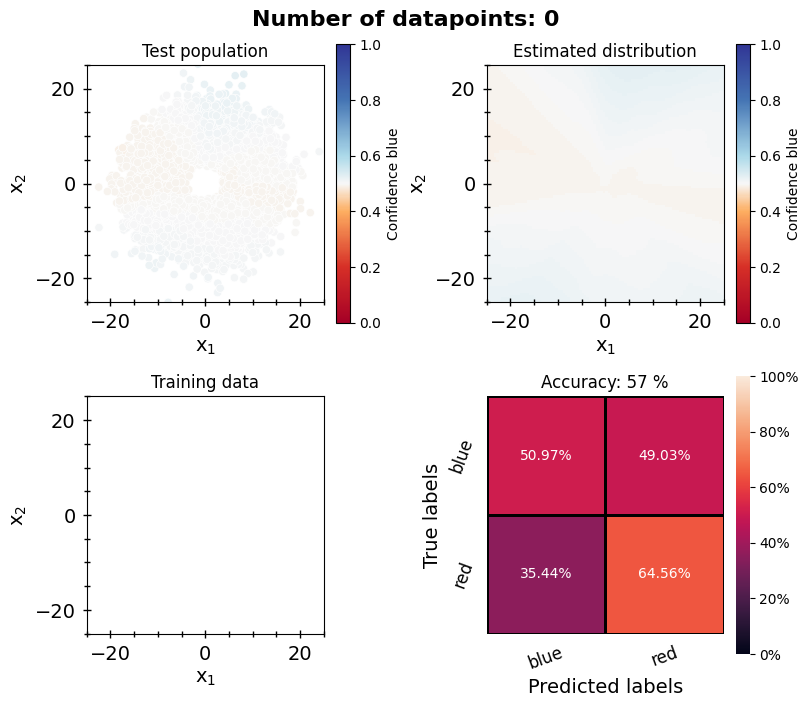

In [40]:
truth, logits = predict_classifier(model, val_dataset, 2, 100, device)
preds = torch.argmax(logits, dim=-1).flatten()
val_data["Prediction"] = preds
val_data["Truth"] = truth
#Get softmax score for blue
val_data["Confidence"] = torch.softmax(logits, dim=-1)[:,0]
grid_df = predict_grid(model, x1_key, x2_key, device)

# Plot
fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (8, 7), layout="constrained")

axs[0][0] = plot_results(val_data, "Confidence", axs[0][0], "Test population")
axs[0][1] = plot_grid(grid_df, "Confidence", axs[0][1], "Estimated distribution")
axs[1][1] = plot_conf_matrix(val_data, "Truth", "Prediction", ["blue", "red"], axs[1][1])
axs[1][0] = plot_data(train_data[0:0], axs[1][0], "Training data")

cmap = red_blue_cmap()
hue_norm = mpl.colors.Normalize(vmin=0, vmax=1, clip=False)
fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm, cmap=cmap), label=r'Confidence blue', ax=axs[0][0])
fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm, cmap=cmap), label=r'Confidence blue', ax=axs[0][1])

fig.suptitle(f"Number of datapoints: 0", size=16, fontweight="bold")

 62%|██████▎   | 50/80 [00:40<00:24,  1.23it/s]


Stopping training early at epoch 50


100%|██████████| 50/50 [00:00<00:00, 448.30it/s]


<Axes: xlabel='Iteration'>

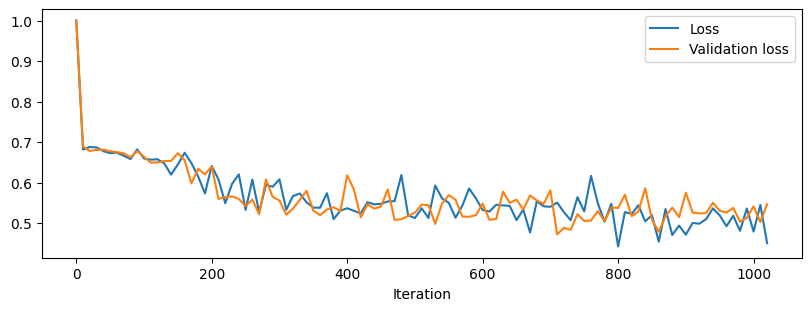

In [41]:
train_dataset = torch.utils.data.TensorDataset(X_train[0:5000], Y_train[0:5000])
training_results = train_classifier(model, train_dataset, 
                         val_dataset, batchsize=2**8, epochs = 80, 
                         device = device, optimizer = optimizer, early_stopping=patience)
truth, logits = predict_classifier(model, val_dataset, 2, 100, device)
preds = torch.argmax(logits, dim=-1).flatten()
fig, axs = plt.subplots(nrows = 1, ncols = 1, figsize = (8, 3), layout="constrained")
training_results.plot("Iteration", ["Loss", "Validation loss"], ax=axs)

100%|██████████| 100/100 [00:00<00:00, 452.04it/s]


Text(0.5, 0.98, 'Number of datapoints: 5000')

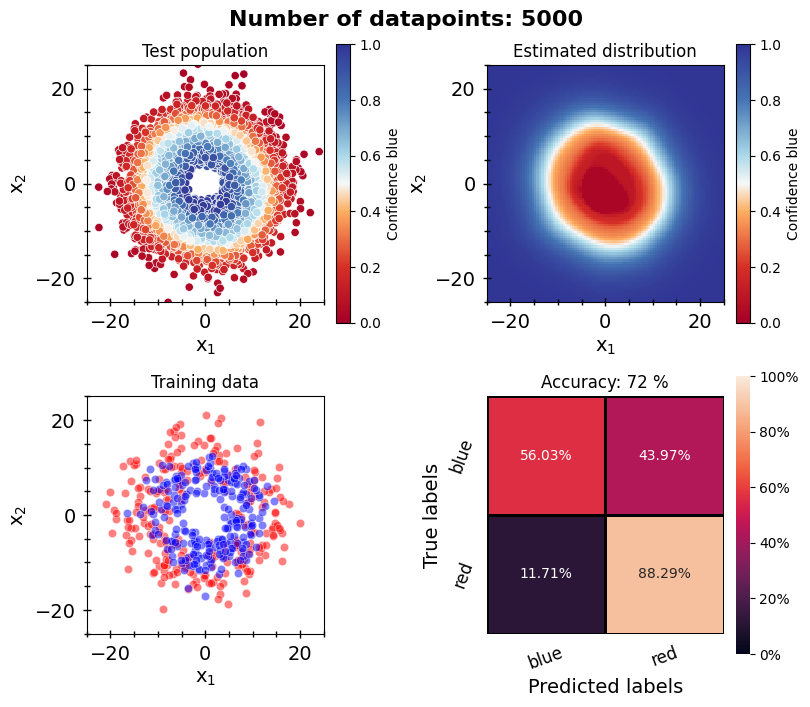

In [42]:
truth, logits = predict_classifier(model, val_dataset, 2, 100, device)
preds = torch.argmax(logits, dim=-1).flatten()
val_data["Prediction"] = preds
val_data["Truth"] = truth
#Get softmax score for blue
val_data["Confidence"] = torch.softmax(logits, dim=-1)[:,1]
accuracy = accuracy_score(val_data["Truth"], val_data["Prediction"], normalize=True)
grid_df = predict_grid(model, x1_key, x2_key, device)

# Plot
fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (8, 7), layout="constrained")

axs[0][0] = plot_results(val_data, "Confidence", axs[0][0], "Test population")
axs[0][1] = plot_grid(grid_df, "Confidence", axs[0][1], "Estimated distribution")
axs[1][1] = plot_conf_matrix(val_data, "Truth", "Prediction", ["blue", "red"], axs[1][1])
axs[1][0] = plot_data(train_data[0:500], axs[1][0], "Training data")

cmap = red_blue_cmap()
hue_norm = mpl.colors.Normalize(vmin=0, vmax=1, clip=False)
fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm, cmap=cmap), label=r'Confidence blue', ax=axs[0][0])
fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm, cmap=cmap), label=r'Confidence blue', ax=axs[0][1])

fig.suptitle(f"Number of datapoints: {len(train_dataset)}", size=16, fontweight="bold")

In [43]:
mean_val, variance_val = mc_predictions(model, val_dataset, 2**8, 200, 2, len(val_dataset))
preds = np.argmax(mean_val, axis=-1).flatten()
val_data["Prediction_MC"] = preds
#Get average softmax score for blue

In [44]:
val_data["Confidence_MC"] = scipy.special.softmax(mean_val, axis=-1)[:,1]
# Error is the same for both scores
val_data["Error_MC"] = np.sqrt(variance_val[:,0])

In [45]:
grid_df_MC = predict_grid(model, x1_key, x2_key, device, mcdropout=True)

Text(0.5, 0.98, 'Number of datapoints: [250, 1000, 2000, 3000, 4000, 5000]')

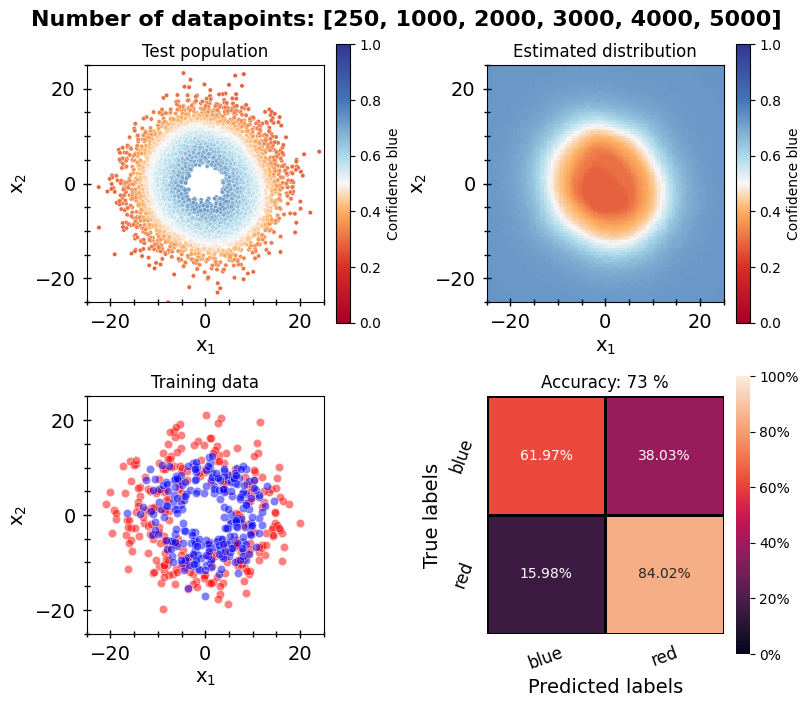

In [50]:

fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (8, 7), layout="constrained")

axs[0][0] = plot_results(val_data, "Confidence_MC", axs[0][0], "Test population", error_key="Error_MC")
axs[0][1] = plot_grid(grid_df_MC, "Confidence_MC", axs[0][1], "Estimated distribution")
axs[1][1] = plot_conf_matrix(val_data, "Truth", "Prediction_MC", ["blue", "red"], axs[1][1])
axs[1][0] = plot_data(train_data[0:500], axs[1][0], "Training data")

cmap = red_blue_cmap()
hue_norm = mpl.colors.Normalize(vmin=0, vmax=1, clip=False)
fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm, cmap=cmap), label=r'Confidence blue', ax=axs[0][0])
fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm, cmap=cmap), label=r'Confidence blue', ax=axs[0][1])

fig.suptitle(f"Number of datapoints: {n_data}", size=16, fontweight="bold")

In [47]:
val_data

,color,x1,x2,a1,a2,r1,r2,r_x,a_x,class,Prediction,Truth,Confidence,Prediction_MC,Confidence_MC,Error_MC
0,red,-10.685982,0.247318,3.107515,3.102613,13.685925,3,10.688843,3.118453,0,1,0.0,0.616423,1,0.540409,0.054775
1,red,6.517934,18.842814,1.225701,0.080292,16.946496,3,19.938283,1.237769,0,0,0.0,0.042352,0,0.285798,0.036152
2,blue,10.101325,7.399758,0.591001,0.172946,9.555816,3,12.521709,0.632241,1,0,1.0,0.414764,0,0.432624,0.087530
3,blue,6.168565,3.672720,0.340686,2.655884,9.694243,3,7.179141,0.537025,1,1,1.0,0.760972,1,0.629859,0.046992
4,blue,-6.823455,-6.068953,3.562035,1.977482,9.893021,3,9.131907,3.868535,1,1,1.0,0.676009,1,0.578498,0.032697
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,blue,10.516936,4.502822,0.285772,0.468822,8.683448,3,11.440339,0.404535,1,1,1.0,0.510532,0,0.483613,0.074820
4996,red,11.995977,-10.837092,5.447627,2.568009,18.603909,3,16.166200,5.548498,0,0,0.0,0.270298,0,0.379171,0.101496
4997,blue,-2.321882,-5.453356,3.916992,2.283827,7.437896,3,5.927076,4.309865,1,1,1.0,0.974180,1,0.713603,0.035650
4998,red,13.664635,7.015536,0.412229,0.323295,12.486160,3,15.360338,0.474317,0,0,0.0,0.197077,0,0.340914,0.072501


Text(0.5, 1.0, '[250, 1000, 2000, 3000, 4000, 5000] training points')

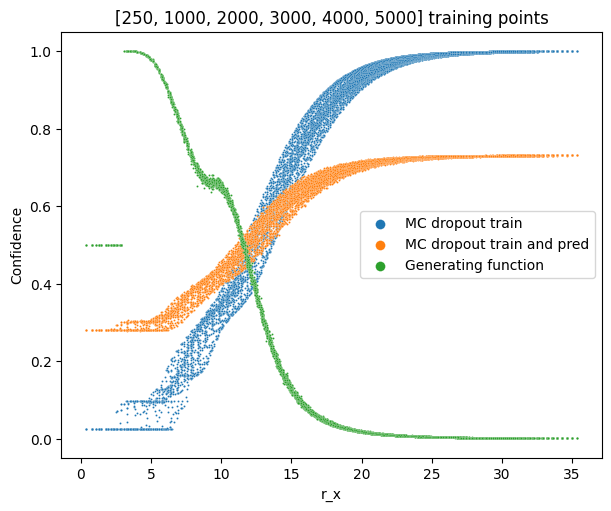

In [48]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize= (6, 5), layout="constrained")
sn.scatterplot(grid_df, x="r_x", y="Confidence", s=2, label="MC dropout train", ax = ax)
sn.scatterplot(grid_df_MC, x="r_x", y="Confidence_MC", s=2, label="MC dropout train and pred", ax = ax)
sn.scatterplot(truth_data, x="r_x", y="P_blue_given_x", s=2, ax = ax, label="Generating function")
ax.legend(markerscale=5)
ax.set_title(f"{n_data} training points")

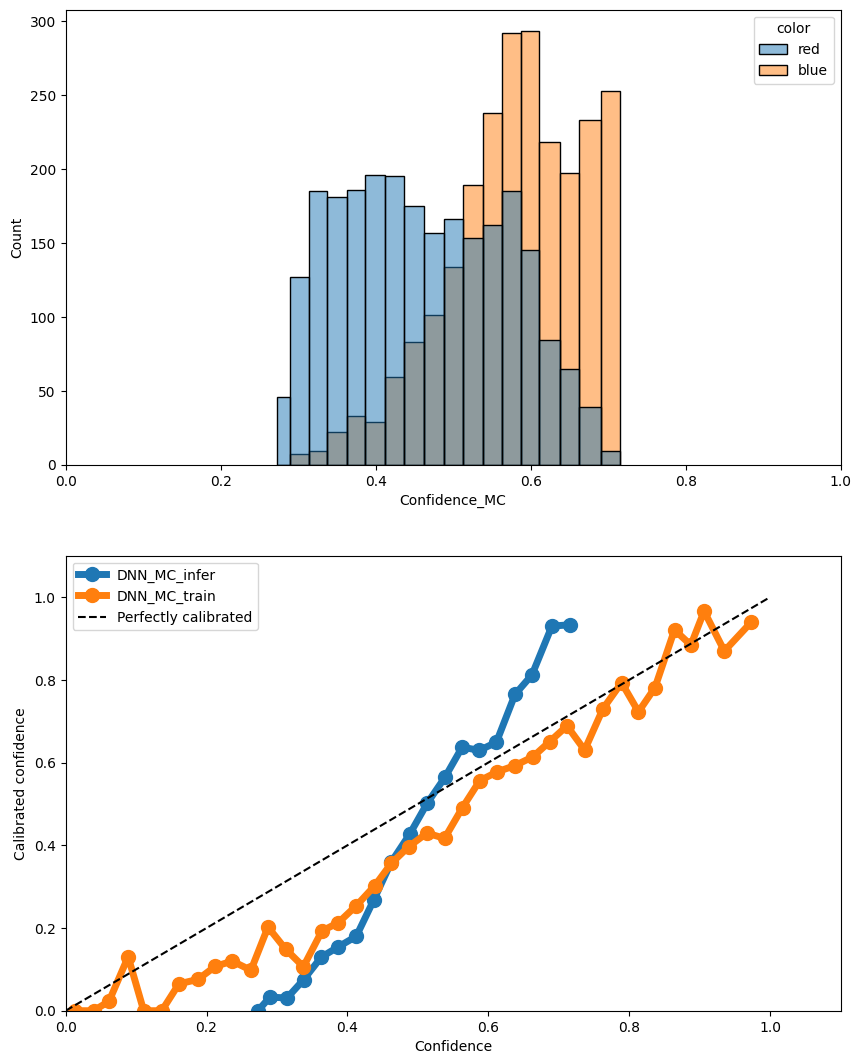

In [49]:
from sklearn.calibration import CalibrationDisplay
from sklearn.calibration import calibration_curve

#Get confidence for red
val_data["Confidence_MC"] = scipy.special.softmax(mean_val, axis=-1)[:,1]
prob_cal_MC, prob_pred_MC = calibration_curve(val_data["Truth"], val_data["Confidence_MC"], n_bins=40, strategy="uniform")
pred_bins_MC=list(prob_pred_MC)

#Get confidence for red
val_data["Confidence"] = torch.softmax(logits, dim=-1)[:,1]
prob_cal, prob_pred = calibration_curve(val_data["Truth"], val_data["Confidence"], n_bins=40, strategy="uniform")
pred_bins=list(prob_pred)

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 13))
sn.histplot(val_data, x="Confidence_MC", hue="color", ax=ax[0], stat="count", bins=pred_bins_MC)
ax[0].set_xlim(0,1)
ax[1].plot(prob_pred_MC, prob_cal_MC, linewidth=5, markersize=10, marker="o", label ="DNN_MC_infer")
ax[1].plot(prob_pred, prob_cal, linewidth=5, markersize=10, marker="o", label ="DNN_MC_train")
ax[1].set_xlim(0,1.1)
ax[1].set_ylim(0,1.1)
x = np.linspace(0, 1, 10)
ax[1].plot(x, x, color="black", linestyle="--", label="Perfectly calibrated")
ax[1].set_xlabel("Confidence")
ax[1].set_ylabel("Calibrated confidence")
ax[1].legend()